###CNN for Determining Pressure Distribution in a Prosthetic Socket


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

# Define input layer
inputs = Input(shape=(3, 5, 1))  # Assuming grayscale images

# Convolutional layers
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# Flatten layer
flatten = Flatten()(pool2)

# Dense layers
dense1 = Dense(128, activation='relu')(flatten)
embeddings = Dense(2, activation = None, use_bias=False)(dense1)
output = Dense(5, activation='softmax')(dense1)  # 5 output categories

# Create model
model = Model(inputs=inputs, outputs=output)
model_embed = Model(inputs=model.input, outputs=model.get_layer('embeddings').output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

ValueError: Exception encountered when calling layer "max_pooling2d" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,3,32].

Call arguments received by layer "max_pooling2d" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 3, 32), dtype=float32)

In [ ]:
!pip install keras-tcn
!pip install darts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm

from tcn import TCN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Pressure Sensor Maching Learning/Current Data/data_test1_20cyclic_1314N.csv")
data

,Time (s),F0 (V),F1 (V),F2 (V),F3 (V),F4 (V),F5 (V),F6 (V),F7 (V)
0,2.34,0.58,0.59,0.58,0.59,0.58,0.59,0.58,0.59
1,2.97,0.58,0.59,0.59,0.58,0.58,0.59,0.58,0.58
2,3.59,0.58,0.58,0.58,0.59,0.58,0.59,0.58,0.58
3,4.22,0.58,0.58,0.58,0.59,0.58,0.59,0.58,0.58
4,4.84,0.58,0.58,0.58,0.58,0.58,0.59,0.58,0.58
...,...,...,...,...,...,...,...,...,...
352,222.34,0.58,0.59,0.59,0.58,0.58,0.58,0.58,0.58
353,222.97,0.58,0.59,0.59,0.58,0.58,0.58,0.58,0.59
354,223.59,0.58,0.59,0.59,0.58,0.58,0.59,0.58,0.59
355,224.22,0.58,0.59,0.59,0.58,0.58,0.59,0.58,0.58


In [ ]:
# Define min-max normalization function
def min_max_normalize(column):
    min_val = 0.58
    max_val = 3.3
    return (column - min_val) / (max_val - min_val)

# Apply normalization function to entire DataFrame
normalized_fsr = data.iloc[:, 1:].apply(min_max_normalize)
normalized_fsr

,F0 (V),F1 (V),F2 (V),F3 (V),F4 (V),F5 (V),F6 (V),F7 (V)
0,0.0,0.003676,0.000000,0.003676,0.0,0.003676,0.0,0.003676
1,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.000000
2,0.0,0.000000,0.000000,0.003676,0.0,0.003676,0.0,0.000000
3,0.0,0.000000,0.000000,0.003676,0.0,0.003676,0.0,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.003676,0.0,0.000000
...,...,...,...,...,...,...,...,...
352,0.0,0.003676,0.003676,0.000000,0.0,0.000000,0.0,0.000000
353,0.0,0.003676,0.003676,0.000000,0.0,0.000000,0.0,0.003676
354,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.003676
355,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.000000


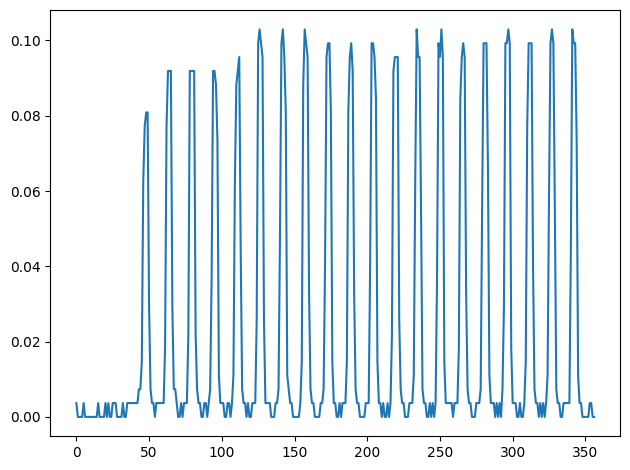

In [ ]:
normalized_fsr["F7 (V)"].plot()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TCNModel

# Convert full data frame into a darts TimeSeries
tsla_darts_ts = TimeSeries.from_dataframe(normalized_fsr)

# Split up tsla_darts_ts into target and past covariates TimeSeries
past_covariates = tsla_darts_ts.drop_columns(['F7 (V)'])
target = tsla_darts_ts.drop_columns(["F0 (V)", "F1 (V)", "F2 (V)", "F3 (V)", "F4 (V)", "F5 (V)", "F6 (V)"])
print(target)

# # scale the past_covariates
# scaler = Scaler()
# past_covariates = scaler.fit_transform(past_covariates)

# # scale the target
# scaler = Scaler()
# target = scaler.fit_transform(target)

# split target
train_target, val_target = target.split_after(300)

# split past_covariates
train_past_covariates, val_past_covariates = past_covariates.split_after(300)

# instantiate the TCN model (using the default architecture from darts)
deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=2,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=40, # past 6 hours
    output_chunk_length=20, # Forecast an hour ahead
)

# train
deeptcn.fit(series=train_target, past_covariates=train_past_covariates, verbose=True)

<TimeSeries (DataArray) (time: 357, component: 1, sample: 1)>
array([[[0.00367647]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.00367647]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

...

       [[0.00367647]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.00367647]],

       [[0.00367647]],

       [[0.        ]],

       [[0.        ]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 349 350 351 352 353 354 355 356
  * component  (component) object 'F7 (V)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | res_blocks    | ModuleList       | 296   
---------------------------------------------------
296       Trainable params
0         Non-trainable params
296       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, batch_size=32, n_epochs=2, optimizer_kwargs={'lr': 0.001}, random_state=0, input_chunk_length=40, output_chunk_length=20)

In [ ]:
backtest_en = deeptcn.historical_forecasts(
    series=target,
    past_covariates=past_covariates,
    start=300,
    forecast_horizon=20,
    retrain=False,
    verbose=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


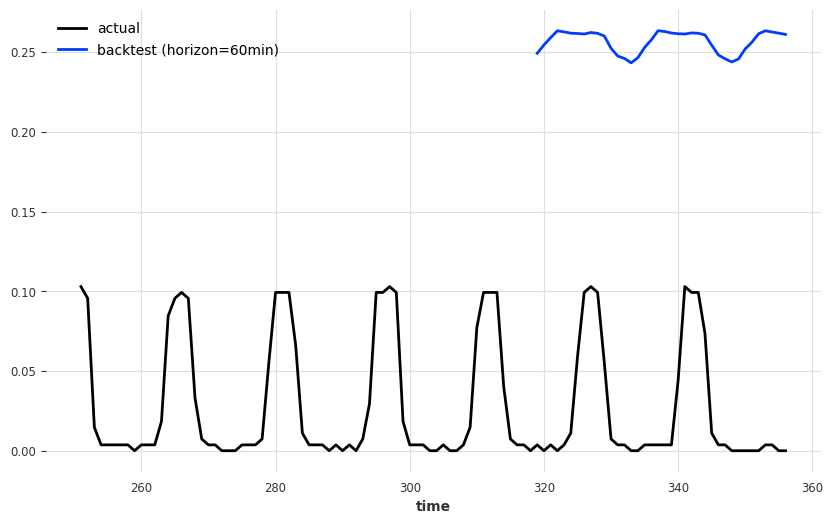

In [ ]:

plt.figure(figsize=(10, 6))
target.drop_before(250).plot(label="actual")
backtest_en.plot(label="backtest (horizon=60min)")
plt.legend()

In [ ]:
FSR_names = ["F0 (V)", "F1 (V)", "F2 (V)", "F3 (V)", "F4 (V)", "F5 (V)", "F6 (V)", "F7 (V)"]
normalized_fsr_and_differences = normalized_fsr.copy()

elem = 0

while elem != len(FSR_names)-1:
  for col in FSR_names[elem+1:]:
    normalized_fsr_and_differences.insert(len(normalized_fsr_and_differences.columns), f"diff{FSR_names[elem][1]}{col[1]}", np.abs(normalized_fsr_and_differences[FSR_names[elem]] - normalized_fsr_and_differences[col]))
  elem += 1
normalized_fsr_and_differences

F0 (V)
F1 (V)
F0 (V)
F2 (V)
F0 (V)
F3 (V)
F0 (V)
F4 (V)
F0 (V)
F5 (V)
F0 (V)
F6 (V)
F0 (V)
F7 (V)
F1 (V)
F2 (V)
F1 (V)
F3 (V)
F1 (V)
F4 (V)
F1 (V)
F5 (V)
F1 (V)
F6 (V)
F1 (V)
F7 (V)
F2 (V)
F3 (V)
F2 (V)
F4 (V)
F2 (V)
F5 (V)
F2 (V)
F6 (V)
F2 (V)
F7 (V)
F3 (V)
F4 (V)
F3 (V)
F5 (V)
F3 (V)
F6 (V)
F3 (V)
F7 (V)
F4 (V)
F5 (V)
F4 (V)
F6 (V)
F4 (V)
F7 (V)
F5 (V)
F6 (V)
F5 (V)
F7 (V)
F6 (V)
F7 (V)


,F0 (V),F1 (V),F2 (V),F3 (V),F4 (V),F5 (V),F6 (V),F7 (V),diff01,diff02,...,diff34,diff35,diff36,diff37,diff45,diff46,diff47,diff56,diff57,diff67
0,0.0,0.003676,0.000000,0.003676,0.0,0.003676,0.0,0.003676,0.003676,0.000000,...,0.003676,0.000000,0.003676,0.000000,0.003676,0.0,0.003676,0.003676,0.000000,0.003676
1,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.000000,0.003676,0.003676,...,0.000000,0.003676,0.000000,0.000000,0.003676,0.0,0.000000,0.003676,0.003676,0.000000
2,0.0,0.000000,0.000000,0.003676,0.0,0.003676,0.0,0.000000,0.000000,0.000000,...,0.003676,0.000000,0.003676,0.003676,0.003676,0.0,0.000000,0.003676,0.003676,0.000000
3,0.0,0.000000,0.000000,0.003676,0.0,0.003676,0.0,0.000000,0.000000,0.000000,...,0.003676,0.000000,0.003676,0.003676,0.003676,0.0,0.000000,0.003676,0.003676,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.003676,0.0,0.000000,0.000000,0.000000,...,0.000000,0.003676,0.000000,0.000000,0.003676,0.0,0.000000,0.003676,0.003676,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.0,0.003676,0.003676,0.000000,0.0,0.000000,0.0,0.000000,0.003676,0.003676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
353,0.0,0.003676,0.003676,0.000000,0.0,0.000000,0.0,0.003676,0.003676,0.003676,...,0.000000,0.000000,0.000000,0.003676,0.000000,0.0,0.003676,0.000000,0.003676,0.003676
354,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.003676,0.003676,0.003676,...,0.000000,0.003676,0.000000,0.003676,0.003676,0.0,0.003676,0.003676,0.000000,0.003676
355,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.000000,0.003676,0.003676,...,0.000000,0.003676,0.000000,0.000000,0.003676,0.0,0.000000,0.003676,0.003676,0.000000


,F0 (V),F1 (V),F2 (V),F3 (V),F4 (V),F5 (V),F6 (V),F7 (V),diff01,diff02,diff03,diff04,diff05,diff06,diff07
0,0.0,0.003676,0.000000,0.003676,0.0,0.003676,0.0,0.003676,0.003676,0.000000,0.003676,0.0,0.003676,0.0,0.003676
1,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.000000,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.000000
2,0.0,0.000000,0.000000,0.003676,0.0,0.003676,0.0,0.000000,0.000000,0.000000,0.003676,0.0,0.003676,0.0,0.000000
3,0.0,0.000000,0.000000,0.003676,0.0,0.003676,0.0,0.000000,0.000000,0.000000,0.003676,0.0,0.003676,0.0,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.003676,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.003676,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.0,0.003676,0.003676,0.000000,0.0,0.000000,0.0,0.000000,0.003676,0.003676,0.000000,0.0,0.000000,0.0,0.000000
353,0.0,0.003676,0.003676,0.000000,0.0,0.000000,0.0,0.003676,0.003676,0.003676,0.000000,0.0,0.000000,0.0,0.003676
354,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.003676,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.003676
355,0.0,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.000000,0.003676,0.003676,0.000000,0.0,0.003676,0.0,0.000000


0      0.003676
1      0.003676
2      0.000000
3      0.000000
4      0.000000
         ...   
352    0.003676
353    0.003676
354    0.003676
355    0.003676
356    0.003676
Length: 357, dtype: float64